In [2]:
import json
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
SEGMENT_LENGTH = 123  

class EEGDataset(Dataset):
    def __init__(self, json_file):
        with open(json_file, 'r') as file:
            data = json.load(file)
        
        self.data = []
        for subject in data['subjects']:
            for image in subject['view_images']:
                eeg_signal = image['EEG_signal']
                # Segment the EEG signal
                for i in range(0, len(eeg_signal), SEGMENT_LENGTH):
                    segment = eeg_signal[i:i + SEGMENT_LENGTH]
                    if len(segment) == SEGMENT_LENGTH:
                        self.data.append({
                            "subject": subject['name'],
                            "EEG_signal": segment,
                            "class": image['class'],
                            "age": subject['age'],
                            "sex": subject['sex'],
                            "has_cat": subject['has_cat'],
                            "has_dog": subject['has_dog'],
                            "has_rabbit": subject['has_rabbit']
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        eeg_signal = torch.tensor(item['EEG_signal'], dtype=torch.float)
        return {
            "eeg_signal": eeg_signal,
            "class": item['class'],
            "subject": item['subject'],
            "age": item['age'],
            "sex": item['sex'],
            "has_cat": item['has_cat'],
            "has_dog": item['has_dog'],
            "has_rabbit": item['has_rabbit']
        }


In [9]:
# Dataset object
eeg_dataset = EEGDataset('SynapSee_data.json')


In [11]:
print("Number of samples:", len(eeg_dataset))
print("Sample keys:", eeg_dataset[0].keys())
print("Sample signal shape:", eeg_dataset[0]['eeg_signal'].shape)
eeg_dataset[0]

Number of samples: 3960
Sample keys: dict_keys(['eeg_signal', 'class', 'subject', 'age', 'sex', 'has_cat', 'has_dog', 'has_rabbit'])
Sample signal shape: torch.Size([123, 16])


{'eeg_signal': tensor([[ 28559.7617,  52190.0938, -48605.5898,  ..., -33292.9922,
          -64349.3984, -67577.6406],
         [ 28606.8359,  52267.4102, -48872.8477,  ..., -33466.0391,
          -64411.0664, -67639.3281],
         [ 28606.7012,  52243.6719, -48620.6094,  ..., -33278.7305,
          -64352.5039, -67583.6094],
         ...,
         [ 28604.3770,  52214.7695, -48907.4258,  ..., -33492.4570,
          -64430.6484, -67675.1797],
         [ 28575.9004,  52160.9258, -48646.2266,  ..., -33324.3516,
          -64383.7734, -67623.0547],
         [ 28552.6543,  52165.3516, -48886.3711,  ..., -33509.6016,
          -64430.2227, -67672.5859]]),
 'class': 'cat',
 'subject': 'mateo',
 'age': 23,
 'sex': 1,
 'has_cat': True,
 'has_dog': False,
 'has_rabbit': False}

In [12]:

# DataLoader object
data_loader = DataLoader(eeg_dataset, batch_size=10, shuffle=True)

# DataLoader object for training
for batch in data_loader:
    # Extrae los datos de cada batch
    eeg_signals = batch['eeg_signal']  # This will be a tensor
    classes = batch['class']  
    print("EEG signal shape:", eeg_signals.shape)
    print("Classes:", classes, len(classes))
    break


EEG signal shape: torch.Size([10, 123, 16])
Classes: ['rabbit', 'rabbit', 'rabbit', 'dog', 'control', 'dog', 'dog', 'control', 'control', 'control'] 10


In [8]:
import torch
import torch.nn as nn

class EEGConvLSTM(nn.Module):
    def __init__(self):
        super(EEGConvLSTM, self).__init__()
        # Convolutional layer
        # Assuming the output of conv layer to have 32 channels
        self.conv1 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # LSTM layer
        # Input size depends on the output of the conv layer
        # Let's assume we keep the sequence length the same (123) and have 32 features after convolution
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_length, features) -> (batch_size, features, seq_length)
        x = x.permute(0, 2, 1)

        # Apply convolution
        # Output shape: (batch_size, conv_output_channels, seq_length)
        x = self.conv1(x)

        # Permute x to fit LSTM input requirements
        # LSTM expects input shape: (batch_size, seq_length, features)
        x = x.permute(0, 2, 1)

        # Apply LSTM
        # We only use the output and ignore the hidden and cell states
        x, _ = self.lstm(x)

        return x

# Create the model instance
model = EEGConvLSTM()
print(model)


EEGConvLSTM(
  (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(32, 64, batch_first=True)
)


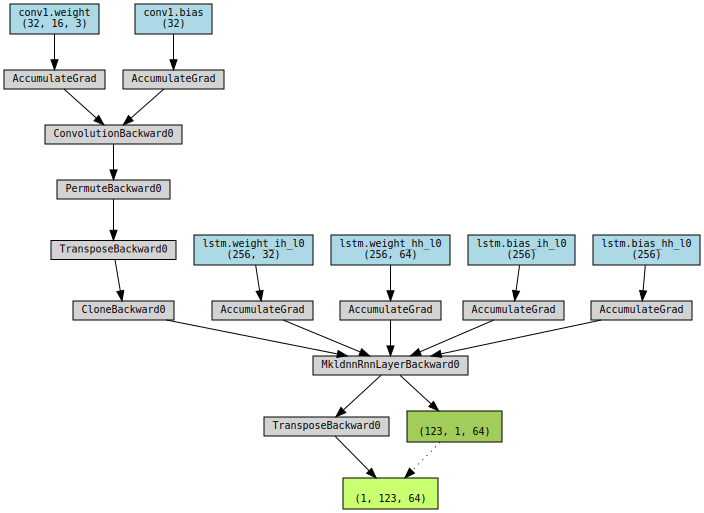

In [10]:
import torch
from torchviz import make_dot

# Create a sample input matching the input dimensions (batch_size, sequence_length, features)
# For example, if your input shape is (batch_size=1, sequence_length=123, features=16)
sample_input = torch.randn(1, 123, 16)

# Assuming your model is named EEGConvLSTM and instantiated as model
model = EEGConvLSTM()

# Perform a forward pass with the sample input
output = model(sample_input)

# Visualize the graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph

In [11]:
model = EEGConvLSTM()
criterion = nn.CrossEntropyLoss()  # If it's a classification problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EEGConvLSTM(
  (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm): LSTM(32, 64, batch_first=True)
)

In [13]:
num_epochs = 10  # Adjust as necessary

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in data_loader:
        # Move data to the correct device
        eeg_signals = batch['eeg_signal'].to(device)

        # Convert 'class' to a tensor and then move to the correct device
        targets = torch.tensor(batch['class']).to(device)

        # Forward pass
        outputs = model(eeg_signals)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    # Validation step, if you have a validation set
    # ...


ValueError: too many dimensions 'str'